## Vegetation Density Index Model
This notebook calculates a composite vegetation index, called *Vegetation Density Index* (VDI), based on a linear regression between two spectral indices over a given set of control points. The idea, originally introduced by [Verstraete et al.](https://ieeexplore.ieee.org/document/536541) as a general approach, is that different desertification areas can be effectively distinguished by partitioning the feature space constructed with pairwise spectral index combinations. 

Let *I* and *J* be the selected spectral indices, **VDI** can first be obtained through a linear regression of the data points *I*
and *J* (i.e., *I=αJ+β*), then calculated as *VDI=k×I−J*, where *k=−1/α*. This index represents a region perpendicular
to the *I–J* feature space, where greener conditions correspond to high values.

These continuous values are subsequently mapped to 5 classes after determining the boundariesof each class using the well-known [Jenks natural break algorithm](https://real-statistics.com/multivariate-statistics/cluster-analysis/jenks-natural-breaks/) based on natural groupings inherent in the models. The classes indicate different levels of vegetation density: *Extremly Low,
Low, Moderate, High, Very High.*


In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import jenkspy

Select two spectral indices from (NDVI, MSAVI, Albedo, TGSI)  

In [2]:
x_axis = 'msavi'
y_axis = 'tgsi'
ind_limits = {}

ind_limits_file = './models/indices-limits.json'
ind_file = "./models/control-points-indices.json"
no_data = -100

Read two files giving the limits of each spectral index, and the measures spectral indices of a set of control points.

In [3]:
with open(ind_limits_file, 'r') as json_file:
    ind_limits = json.load(json_file)
with open(ind_file, 'r') as f:
    data = json.load(f) 
x_list = []
y_list = []
for elt in data:
    if elt[x_axis] != no_data:
        x_list.append(elt[x_axis])
        y_list.append(elt[y_axis])

Normalize spectral values on each axis.

In [4]:
# normalization
def normalize(l,axis):
    norm_l = []
    for x in l:
         norm_l.append((x - ind_limits[axis][0]) / (ind_limits[axis][1] - ind_limits[axis][0]))
    return norm_l

x_norm = normalize(x_list,x_axis)
y_norm = normalize(y_list,y_axis)
    
df = pd.DataFrame({x_axis:x_norm,y_axis:y_norm})

x = np.array(x_norm).reshape((-1, 1))
y = np.array(y_norm)

In this cell, we build the linear regression model, derive the coefficient *k* used to calculate **VDI**, and define the boundaries of each vegetation class.

In [6]:
# create a linear regression model and fit the data
model = LinearRegression().fit(x, y)

# get the parameters of the linear equation
intercept = model.intercept_
slope = model.coef_[0]

# calculate the correlation coefficient
corr_coef = df[x_axis].corr(df[y_axis])
        
# get the R-squared correlation value
r_sq = model.score(x, y)

# Calculate the slope k of the derived linear model
k = 1/(-slope)
       
veg_index = []
for i in range(len(x_norm)):
    veg_index.append(k*x_norm[i]-y_norm[i])
    
print(f'{x_axis.upper()}-{y_axis.upper()} model')
print('------------------------------------')
print(f'Intercept: {intercept:.3f}')
print(f'Slope: {slope:.3f}')
print(f'Correlation coefficient: {corr_coef:.3f}')
print(f'R-squared: {r_sq:.3f}')
print (f'Slope of the derived model: {k:.3f}')

MSAVI-TGSI model
------------------------------------
Intercept: 1.388
Slope: -0.895
Correlation coefficient: -0.706
R-squared: 0.498
Slope of the derived model: 1.117


We execute *Jenks algorithm* to separate data into vegetation classes based on VDI.

In [7]:
# define the number of classes to create
n_classes = 5

# use the jenkspy package to calculate the breaks
breaks = jenkspy.jenks_breaks(veg_index, n_classes=5)

repartition = [0,0,0,0,0]
veg_class = []
for i in range(len(veg_index)):
    if veg_index[i] <= breaks[1]:
        repartition[0] += 1
        veg_class.append(0)
    elif veg_index[i] <= breaks[2]:
        repartition[1] += 1
        veg_class.append(1)
    elif veg_index[i] <= breaks[3]:
        repartition[2] += 1
        veg_class.append(2)
    elif veg_index[i] <= breaks[4]:
        repartition[3] += 1
        veg_class.append(3)
    else: 
        repartition[4] += 1
        veg_class.append(4)

formatted_breaks = [f"{num:.5f}" for num in breaks]
print(f'Limits of the vegetation classes: {", ".join(formatted_breaks)}')
print('Number of data samples per class:', repartition)

Limits of the vegetation classes: -0.04605, 0.27801, 0.31303, 0.35419, 0.40455, 0.52289
Number of data samples per class: [1390, 1904, 1265, 883, 558]


We save the model in a *json* file

In [8]:
results = {}
results['x_axis'] = x_axis
results['y_axis'] = y_axis
results['slope'] = k
results['classes-limits'] = breaks
results['x-axis-limits'] = ind_limits[x_axis]
results['y-axis-limits'] = ind_limits[y_axis]
with open('./models/vdi-'+x_axis+'-'+y_axis+'.json', 'w') as json_file:
        json.dump(results, json_file)

Make a scatterplot of the control points showing their associated vegetation class.

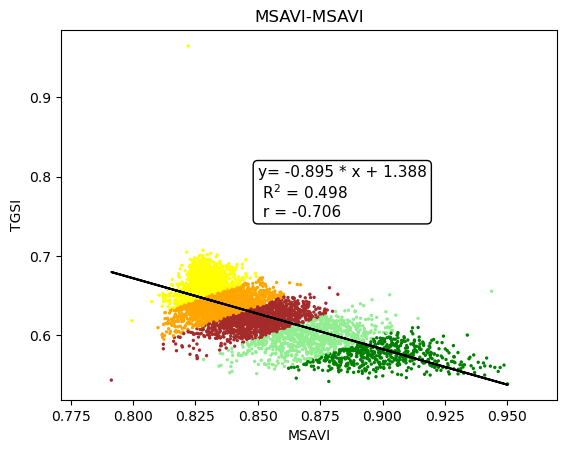

In [9]:
class_colors = {
    4: "green",
    3: "#90EE90",
    2: "brown",
    1: "#FFA500",
    0: 'yellow'
}

# map the class labels to colors using the class_colors dictionary
colors = pd.Series(veg_class).map(class_colors)

# create a scatter plot using matplotlib
plt.scatter(df[x_axis], df[y_axis], c=colors,  s=2) #colors)
# Add regression line
plt.plot(x, slope*x + intercept, color='black')

# set axis labels and title
plt.xlabel(x_axis.upper())
plt.ylabel(y_axis.upper())
plt.title(x_axis.upper()+'-'+x_axis.upper())

# set the range of the x and y-axis
plt.xlim(min(x_norm)-0.02, max(x_norm)+0.02)
plt.ylim(min(y_norm)-0.02, max(y_norm)+0.02)

txt= f"y= {slope:.3f} * x + {intercept:.3f}\n R$^2$ = {r_sq:.3f} \n r = {corr_coef:.3f}"

plt.text(0.85, 0.75, txt, fontsize=11, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

# show the plot
plt.savefig('./models/'+x_axis+'-'+y_axis+'-model.png')
plt.show()